# Topic 25-Part 2: Evaluating Classifiers, Dealing with Class Imbalance, and `GridSearchCV`

- onl01-dtsc-ft-022221
- 05/07/21

## Announcements

- Blog Post Deadline Extended until Monday at 10 AM EST.

## Overview

- Last time:
    - Types of machine learning.
        - Supervised vs Unsupervised Learning
        - Regression vs Classification 
    - From Linear to Logistic Regression - Theory
    - Applying Logistic Regression with `scikit-learn`
        - Proper preprocessing with train-test-split.
    - Evaluating Classifiers
        - Confusion Matrices
        - Accuracy, ~~Precision, Recall, F1-Score~~



- Today
    - Classification Metrics 
        - Confusion Matrices
        - Accuracy, Precision, Recall, F1-Score
        - ROC-AUC curve
    - GridSearchCV
    - Class Imbalance Problems
    - Functionizing evaluating classification models

## Questions?

# Reviewing Part 1: Intro to Logistic Regression

## Predict Passenger Survival on the Titanic with `scikit-learn`

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 


# import statsmodels.api as sm

In [2]:
url = "https://raw.githubusercontent.com/jirvingphd/dsc-dealing-missing-data-lab-online-ds-ft-100719/master/titanic.csv"
df = pd.read_csv(url,index_col=0,na_values='?')
relevant_columns = ['Pclass', 'Age', 'SibSp', 'Fare', 'Sex', 'Embarked', 'Survived']
df = df[relevant_columns]
df.head()

,Pclass,Age,SibSp,Fare,Sex,Embarked,Survived
0,3.0,22.0,1,7.2500,male,S,0
1,1.0,38.0,1,71.2833,female,C,1
2,3.0,26.0,0,7.9250,female,S,1
3,1.0,35.0,1,53.1000,female,S,1
4,3.0,35.0,0,8.0500,male,S,0


In [3]:
df['Survived'].value_counts(normalize=True,dropna=False)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Text(0.5, 0.98, 'X Features vs Survived')

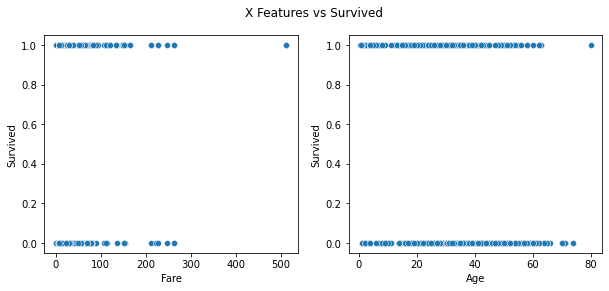

In [4]:
fig,ax= plt.subplots(ncols=2,figsize=(10,4))
sns.scatterplot(data=df, x='Fare',y='Survived',ax=ax[0])
sns.scatterplot(data=df, x='Age',y='Survived',ax=ax[1])
fig.suptitle('X Features vs Survived')

Text(0.5, 0.98, 'X Features vs Survived - Regression')

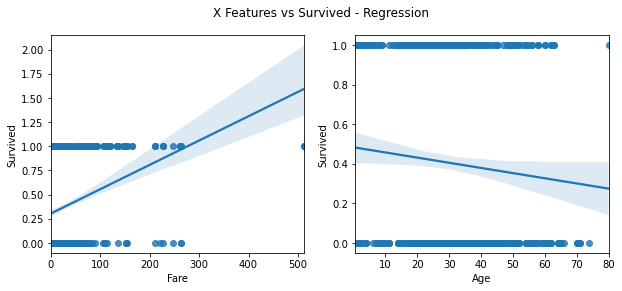

In [5]:
fig,ax= plt.subplots(ncols=2,figsize=(10,4))
sns.regplot(data=df, x='Fare',y='Survived',ax=ax[0])
sns.regplot(data=df, x='Age',y='Survived',ax=ax[1])
fig.suptitle('X Features vs Survived - Regression')

### Q: What are the preprocessing steps I need to perform before I create the model?

- Recast data types
- Train-test-split
- Fill/drop in missing/null values
- Feature Selection / Feature Engineering (interaction terms)
- Handling categorial variables
    - One Hot Encoding 
    - Label Encoding
- Handling Outliers (maybe)
- Normalizing/Standardizing our data

- **Multicollinearity (does it still matter as much for Logistic?)**



In [6]:
## Check out the .info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    842 non-null    float64
 1   Age       714 non-null    float64
 2   SibSp     891 non-null    int64  
 3   Fare      891 non-null    float64
 4   Sex       891 non-null    object 
 5   Embarked  889 non-null    object 
 6   Survived  891 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 55.7+ KB


In [7]:
## Check Object cols value_counts
display(df['Embarked'].value_counts(dropna=False),
        df['Sex'].value_counts(dropna=False))

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

male      577
female    314
Name: Sex, dtype: int64

### Preprocessing

In [8]:
## Separate X and y and train-test-split
target = 'Survived'

y = df[target]
X = df.drop(target, axis=1)

# Perform test train split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,)


In [9]:
## Check for nulls in training set
X_train.isna().sum()

Pclass       37
Age         120
SibSp         0
Fare          0
Sex           0
Embarked      1
dtype: int64

In [10]:
df['Pclass'].value_counts(normalize=True,dropna=False)

3.0    0.526375
1.0    0.225589
2.0    0.193042
NaN    0.054994
Name: Pclass, dtype: float64

In [11]:
df['Embarked'].value_counts(normalize=True,dropna=False)

S      0.722783
C      0.188552
Q      0.086420
NaN    0.002245
Name: Embarked, dtype: float64

In [12]:
pclass_counts = dict(X_train['Pclass'].value_counts(normalize=True))
pclass_counts

{3.0: 0.552901023890785, 1.0: 0.23890784982935154, 2.0: 0.20819112627986347}

### 🚩Part 2 Update re filling nulls using class balances/prob:

In [13]:
### Filling in from sample distribution is easier than what i was doing yesterday.
p_class = X_train['Pclass'].fillna(np.random.choice(list(pclass_counts.keys()),
                                                  p=list(pclass_counts.values())))
p_class.isna().sum()

0

In [14]:
p_class.value_counts()

3.0    361
1.0    140
2.0    122
Name: Pclass, dtype: int64

#### Original Part 1 Continued

In [15]:
X_train['Pclass'].value_counts(dropna=False)

3.0    324
1.0    140
2.0    122
NaN     37
Name: Pclass, dtype: int64

In [16]:
SimpleImputer()

SimpleImputer()

In [17]:
## Specify which values to impute with which method

## Most frequent
mode_cols =['Pclass','Embarked']
## Fill with median
median_cols = ['Age']


In [18]:
## Copying X_train and X_test as start of X_train_tf,X_test_tf
X_train_tf = X_train.copy()
X_test_tf = X_test.copy()

In [19]:
## Impute the columns with most-frequent value
impute_mode = SimpleImputer(strategy='most_frequent')
X_train_tf[mode_cols] = impute_mode.fit_transform(X_train_tf[mode_cols])
X_test_tf[mode_cols] = impute_mode.transform(X_test_tf[mode_cols])
## Verify it worked
X_train_tf.isna().sum()

Pclass        0
Age         120
SibSp         0
Fare          0
Sex           0
Embarked      0
dtype: int64

In [20]:
## Impute the columns with most-frequent value
impute_median = SimpleImputer(strategy='median')
X_train_tf[median_cols] = impute_median.fit_transform(X_train_tf[median_cols])
X_test_tf[median_cols] = impute_median.transform(X_test_tf[median_cols])
## Verify it worked
X_train_tf.isna().sum(), X_test_tf.isna().sum()

(Pclass      0
 Age         0
 SibSp       0
 Fare        0
 Sex         0
 Embarked    0
 dtype: int64,
 Pclass      0
 Age         0
 SibSp       0
 Fare        0
 Sex         0
 Embarked    0
 dtype: int64)

In [21]:
X_train_tf['Pclass'] = X_train_tf['Pclass'].astype(str)
X_test_tf['Pclass'] = X_test_tf['Pclass'].astype(str)

X_train_tf

,Pclass,Age,SibSp,Fare,Sex,Embarked
720,2.0,6.00,0,33.0000,female,S
803,3.0,0.42,0,8.5167,male,C
344,2.0,36.00,0,13.0000,male,S
620,3.0,27.00,1,14.4542,male,C
867,1.0,31.00,0,50.4958,male,S
...,...,...,...,...,...,...
117,2.0,29.00,1,21.0000,male,S
660,1.0,50.00,2,133.6500,male,S
445,1.0,4.00,0,81.8583,male,S
150,2.0,51.00,0,12.5250,male,S


In [22]:
## Specifing which cols to encode and which to scale.
#  make cat_cols and num_cols
cat_cols = X_train_tf.select_dtypes('O').columns
num_cols = X_train_tf.select_dtypes('number').columns
num_cols,cat_cols

(Index(['Age', 'SibSp', 'Fare'], dtype='object'),
 Index(['Pclass', 'Sex', 'Embarked'], dtype='object'))

In [23]:
## Encode cat_cols
encoder = OneHotEncoder(sparse=False,drop='first')
train_cat_cols = encoder.fit_transform(X_train_tf[cat_cols])
test_cat_cols = encoder.transform(X_test_tf[cat_cols])
train_cat_cols

array([[1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [1., 0., 1., 0., 1.],
       ...,
       [0., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.]])

In [24]:
train_cat_cols = pd.DataFrame(train_cat_cols,columns=encoder.get_feature_names(cat_cols))
test_cat_cols =  pd.DataFrame(test_cat_cols,columns=encoder.get_feature_names(cat_cols))
test_cat_cols

,Pclass_2.0,Pclass_3.0,Sex_male,Embarked_Q,Embarked_S
0,1.0,0.0,1.0,0.0,1.0
1,0.0,1.0,1.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
263,1.0,0.0,0.0,0.0,1.0
264,1.0,0.0,0.0,0.0,1.0
265,0.0,1.0,0.0,0.0,1.0
266,0.0,1.0,1.0,0.0,0.0


In [25]:
## Scaling Num_cols
scaler = StandardScaler()
train_num_cols = pd.DataFrame(scaler.fit_transform(X_train_tf[num_cols]),
                              columns=num_cols)
test_num_cols =  pd.DataFrame(scaler.transform(X_test_tf[num_cols]),
                              columns=num_cols)
train_num_cols

,Age,SibSp,Fare
0,-1.781260,-0.482461,0.041117
1,-2.199003,-0.482461,-0.474742
2,0.464667,-0.482461,-0.380279
3,-0.209112,0.436724,-0.349640
4,0.090345,-0.482461,0.409751
...,...,...,...
618,-0.059383,0.436724,-0.211721
619,1.512766,1.355909,2.161796
620,-1.930989,-0.482461,1.070554
621,1.587630,-0.482461,-0.390288


In [26]:
## Combine Num and Cat Cols
X_train_tf = pd.concat([train_num_cols,train_cat_cols],axis=1)
X_test_tf = pd.concat([test_num_cols,test_cat_cols],axis=1)
X_test_tf

,Age,SibSp,Fare,Pclass_2.0,Pclass_3.0,Sex_male,Embarked_Q,Embarked_S
0,0.314938,-0.482461,-0.380279,1.0,0.0,1.0,0.0,1.0
1,-1.781260,-0.482461,-0.391341,0.0,1.0,1.0,0.0,1.0
2,2.560865,0.436724,4.887179,0.0,0.0,1.0,0.0,1.0
3,0.015481,-0.482461,-0.391341,0.0,1.0,0.0,0.0,1.0
4,-0.059383,-0.482461,1.682106,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
263,0.389802,-0.482461,-0.211721,1.0,0.0,0.0,0.0,1.0
264,-0.433704,-0.482461,-0.380279,1.0,0.0,0.0,0.0,1.0
265,-0.882890,-0.482461,-0.496252,0.0,1.0,0.0,0.0,1.0
266,-0.733161,0.436724,-0.322512,0.0,1.0,1.0,0.0,0.0


In [29]:
X_train_tf.describe().round(2)


,Age,SibSp,Fare,Pclass_2.0,Pclass_3.0,Sex_male,Embarked_Q,Embarked_S
count,623.00,623.00,623.00,623.0,623.00,623.00,623.00,623.00
mean,0.00,0.00,0.00,0.2,0.58,0.67,0.09,0.73
std,1.00,1.00,1.00,0.4,0.49,0.47,0.29,0.44
min,-2.20,-0.48,-0.65,0.0,0.00,0.00,0.00,0.00
25%,-0.58,-0.48,-0.49,0.0,0.00,0.00,0.00,0.00
50%,-0.06,-0.48,-0.35,0.0,1.00,1.00,0.00,1.00
75%,0.46,0.44,-0.00,0.0,1.00,1.00,0.00,1.00
max,3.76,6.87,10.14,1.0,1.00,1.00,1.00,1.00


## Fitting a Logistic Regression with `scikit-learn`

In [30]:
## Fit a logistic regression model with defaults
log_reg = LogisticRegression(C=1e12)
log_reg.fit(X_train_tf,y_train)

LogisticRegression(C=1000000000000.0)

In [31]:
## Get the model's .score for training and test set 
print(f"Training Score:\t{log_reg.score(X_train_tf,y_train):.2f}")
print(f"Test Score:\t{log_reg.score(X_test_tf,y_test):.2f}")

Training Score:	0.80
Test Score:	0.77


In [32]:
### Getting our model's coefficients
## Our function from last class
def get_coefficients(model,X_train):
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns)
    coeffs['intercept'] = model.intercept_[0]
    return coeffs

## get the model's coefficients
get_coefficients(log_reg,X_train_tf)

Age          -0.466570
SibSp        -0.487100
Fare          0.323358
Pclass_2.0   -0.629940
Pclass_3.0   -1.419940
Sex_male     -2.743428
Embarked_Q    0.079508
Embarked_S   -0.216985
intercept     2.287310
dtype: float64

In [33]:
## Get Predictions for training and test data to check metrics functions
y_hat_train = log_reg.predict(X_train_tf)
y_hat_test = log_reg.predict(X_test_tf)

In [34]:
## Try accuracy_score
metrics.accuracy_score(y_train,y_hat_train)

0.8041733547351525

### How do I know if my accuracy score is good?

> Does your model predict better than chance/just getting the class distribution?
- Compare your accuracy to your normalized value counts for y
- Compare your model against a `DummyClassifier` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

In [35]:
## Check the class balance for the y_train
y_train.value_counts(normalize=True)

0    0.626003
1    0.373997
Name: Survived, dtype: float64

In [36]:
## Check the class balance for y_test
y_test.value_counts(normalize=True)

0    0.593284
1    0.406716
Name: Survived, dtype: float64

In [37]:
from sklearn.dummy import DummyClassifier
## Make and fit  dummy classifier
model = DummyClassifier(strategy='stratified')
model.fit(X_train_tf,y_train)
model.score(X_test_tf,y_test)

0.5261194029850746

In [38]:
## Get the model's .score
print(f"Training Score:\t{model.score(X_train_tf,y_train):.2f}")
print(f"Test Score:\t{model.score(X_test_tf,y_test):.2f}")

Training Score:	0.54
Test Score:	0.56


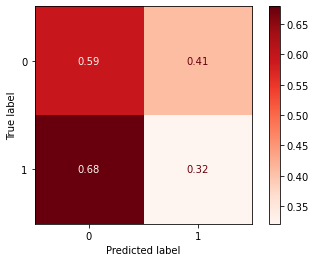

In [39]:
## Check the confusion matrix
metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap='Reds',normalize='true')

> But accuracy isn't the best metric when you have imbalanced classes. 
- Next class we will introduce more classification metrics

## 🚩Revisiting Question from Part 1: Interpreting LogisticRegresion Coefficients

### Resources:


- [Central Lecturer Logistic Regression Notebook (cited below)]( https://nbviewer.jupyter.org/github/flatiron-school/ds-logistic_regression/blob/main/logistic_regression.ipynb)
- [Medium Blog Post on Interpreting Linear Regression and Logistic Regression Coefficients](https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1)

### From [Central Lecturer `logistic_regression.ipynb` Notebook )]( https://nbviewer.jupyter.org/github/flatiron-school/ds-logistic_regression/blob/main/logistic_regression.ipynb):<br>

The **sigmoid function**. <br/>
$$\large\hat{y} = \Large\frac{1}{1 + e^{-\hat{L}}} \large= \Large\frac{1}{1 + e^{-(\beta_0 + ... + \beta_nx_n)}}$$ 


- How do we fit a line to our dependent variable if its values are already stored as probabilities? 
    - We can ***use the inverse of the sigmoid function, and just set our regression equation equal to that.*** 
    - The inverse of the sigmoid function is called the **logit function**, and it looks like this:

$$\large f(y) = \ln\left(\frac{y}{1 - y}\right)$$
- Notice that the domain of this function is $(0, 1)$.

### From the [Medium Blog Post on Interpreting Linear Regression and Logistic Regression Coefficients](https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1)

>"Because of the logit function, logistic regression coefficients represent the log odds that an observation is in the target class (“1”) given the values of its X variables. Thus, these log odd coefficients need to be converted to regular odds in order to make sense of them. Happily, this is done by simply exponentiating the log odds coefficients, which you can do with np.exp()"<br>- [Blog Post](https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1)

In [102]:
coeffs = get_coefficients(log_reg,X_train_tf)
coeffs

Age          -0.425562
SibSp        -0.399269
Fare          0.200675
Pclass_2.0   -0.680162
Pclass_3.0   -1.505889
Sex_male     -2.630981
Embarked_Q   -0.506884
Embarked_S   -0.342220
intercept     2.406901
dtype: float64

In [40]:
## Odds are how much more likely to fall into 1 class than 0 class
## convert log-odds to odds using np.exp


#### Interpreting Odds Coefficients
> ***“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) (when all other variables are held constant).”***

- For "Age"=0.66: 
    - For every 1 sd increase in Age, the odds that the person Survived (class=1) are 0.66 x as large as the odds the person died. 
- For Fare = 1.5:
    - For every increase of 1sd in Fare the odds the person Survived are 1.5 times the odds that they diedd. 
- For Sex_male=0.09
    - The odds that a male survives is 0.09 times greater than the odds they died.
- For Females (1-Sex_male) = .91
    - The odds that a female survived is .91 times greater than the odds they died. 

#### Converting to Probability


$$odds = \frac {probability} {1 - probability}$$

$$probability = \frac {odds} {1 + odds}$$

And so the logit function represents the **log-odds** of success (y=1).

In [41]:
## convert odds to prob


In [105]:
## update function to return 
def get_coefficients(model,X_train,units = "log-odds"):
    """Returns model coefficients. 
    
    Args:
        model: sklearn model with the .coef_ attribute. 
        X_train: dataframe with the feature names as the .columns
        units (str): Can be ['log-odds','odds','prob']
        """
    options = ['log-odds','odds','prob']
    
    if units not in options:
        raise Exception(f'units must be one of {options}')
        
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns)
    coeffs['intercept'] = model.intercept_[0]
    
    if units=='odds':
        coeffs = np.exp(coeffs)
        
    elif units=='prob':
        coeffs = np.exp(coeffs)
        coeffs = coeffs/(1+coeffs)
        

    coeffs.name=units
    return coeffs

In [106]:
coeffs_odds = get_coefficients(log_reg,X_train_tf,units='odds')
coeffs_odds

Age            0.653403
SibSp          0.670810
Fare           1.222228
Pclass_2.0     0.506535
Pclass_3.0     0.221820
Sex_male       0.072008
Embarked_Q     0.602369
Embarked_S     0.710192
intercept     11.099511
Name: odds, dtype: float64

# Part 2: Evaluating Classifiers, Dealing with Class Imbalance, and `GridSearchCV`

- 05/07/21

## Confusion Matrices: Understanding Our Model's Mistakes

- For classification tasks, it can be extremely helpful to examine a "Confusion Matrix" to understand how our model is wrong. 

In [107]:
## Use metrics.confusion_matrix
metrics.confusion_matrix(y_test,y_hat_test)

array([[143,  26],
       [ 30,  69]])

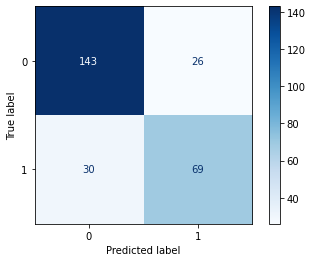

In [108]:
## Use metrics.plot_confusion_matrix
metrics.plot_confusion_matrix(log_reg, X_test_tf,y_test,cmap='Blues')#,
#                              display_labels=["Died",'Survived'])

>- The Confusion Matrix separated out the correct (true) predictions for the positive class (1) and negative class (0). 
```
[TN,FP],
[FN,TP]
```
- **_True Positives (TP)_**: The number of observations where the model predicted the person has the disease (1), and they actually do have the disease (1).

- **_True Negatives (TN)_**: The number of observations where the model predicted the person is healthy (0), and they are actually healthy (0).

- **_False Positives (FP)_**: The number of observations where the model predicted the person has the disease (1), but they are actually healthy (0). 

- **_False Negatives (FN)_**: The number of observations where the model predicted the person is healthy (0), but they actually have the disease (1).


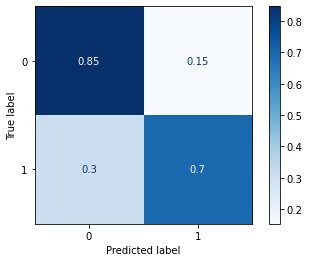

In [109]:
metrics.plot_confusion_matrix(log_reg, X_test_tf,y_test,cmap='Blues',normalize='true')#,

## Evaluation Metrics

> [The 5 Classification Evaluation metrics every Data Scientist must know](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)

- **Classification Metrics are based on the confusion matrices of our model**

```
[TN,FP],
[FN,TP]
```

In [110]:
## Remake the conf matrix (raw counts)
cm = metrics.confusion_matrix(y_test,y_hat_test)
cm

array([[143,  26],
       [ 30,  69]])

In [111]:
## SLice out TN/FP/etc from cm
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]

In [112]:
## Make sure we got the order right
print(TN,FP)
print(FN,TP)

143 26
30 69


### Accuracy

$$ \large \text{Accuracy} = \frac{\text{Number of True Positives + True Negatives}}{\text{Total Observations}} $$

> "Out of all the predictions our model made, what percentage were correct?"
- "Accuracy is the most common metric for classification. It provides a solid holistic view of the overall performance of our 
model."

#### When to use?
- **Accuracy** is good for non-technical audiences (but can be misleading with imbalanced classes)


In [113]:
## calcualte accuracy manually
acc = (TP+TN)/(TP+TN+FP+FN)
acc

0.7910447761194029

In [114]:
## compare against the accuracy_score
metrics.accuracy_score(y_test,y_hat_test)

0.7910447761194029

### Precision

> "**_Precision_** measures what proportion of predicted Positives is truly Positive?


$$ \large \text{Precision} = \frac{\text{Number of True Positives}}{\text{Number of Predicted Positives}} $$


#### When to use?
- **Use precision** when the cost of acting is high and acting on a positive is costly.
   - e.g. Allocating resources/interventions for prisoners who are at-risk for recidivism. 

In [115]:
metrics.precision_score(y_test, y_hat_test)

0.7263157894736842

In [116]:
prec = TP/(FP+TP)
prec

0.7263157894736842

### Recall (AKA Sensitivity)

> **_Recall_** indicates what percentage of the classes we're interested in were actually captured by the model."
$$ \large \text{Recall} = \frac{\text{Number of True Positives}}{\text{Number of Actual Total Positives}} $$ 


#### When to use?
- **Use recall** when the number of true positives/opportunities is small and you don’t want to miss one.
    - e.g. cancer diagnosis. (telling someone they do not have cancer when they actually do is fatal)

In [117]:
metrics.recall_score(y_test, y_hat_test)

0.696969696969697

In [118]:
rec = TP /(TP+FN)
rec

0.696969696969697

#### Sensitivity vs Specificity
- Sensitivity(True Positive rate) measures the proportion of positives that are correctly identified
- Specificity (True Negative rate) measures the proportion of negatives that are correctly identified


> Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

In [119]:
print(metrics.classification_report(y_test,y_hat_test))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       169
           1       0.73      0.70      0.71        99

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.79      0.79      0.79       268



In [120]:
## for binary classification, can get Specifity from 0 class's recall.
report = metrics.classification_report(y_test,y_hat_test,output_dict=True)
sensitivty = report['1']['recall']
specificity = report['0']['recall']

In [121]:
sensitivty

0.696969696969697

In [122]:
specificity

0.8461538461538461

<!-- <img src='https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/precisionrecall.png' width=50%> -->

### $F_1$ Score

F1 score represents the **_Harmonic Mean of Precision and Recall_**.  In short, this means that the F1 score cannot be high without both precision and recall also being high. When a model's F1 score is high, you know that your model is doing well all around. 

> Harmonic Mean: "the reciprocal of the arithmetic mean of the reciprocals of a given set of observatins." - *[Wikipedia](https://en.wikipedia.org/wiki/Harmonic_mean)*

#### Arithmetic Mean:

$$\large \bar{X} = \frac{a+b+c}{n} $$

#### Harmonic Mean:

$$ \large \bar{X} = \frac{n}{\frac{1}{a}+ \frac{1}{b}+ \frac{1}{c}}$$


**The formula for F1 score is:**

> $$ \text{F1 score} =  \frac{2}{\text{Precision}^{-1}\ x\ \text{Recall}^{-1}}= 2\ \frac{\text{Precision}\ x\ \text{Recall}}{\text{Precision} + \text{Recall}} $$

#### When to use?
- **F1 score** is really the most informative about overall model quality.
- BUT is the most difficult to express to a non-tech audience

In [123]:
f1_score = 2*prec*rec / (prec + rec)
print(f1_score)

0.7113402061855671


In [124]:
metrics.f1_score(y_test,y_hat_test)

0.7113402061855671

## Which metric to use?

- **When in doubt, use them all!** 
 -`metrics.classification_report`
 

- **But some good rules of thumb:**
    - **Accuracy** is good for non-technical audiences (but can be misleading with imbalanced classes)
    
    - **Use recall** when the number of true positives/opportunities is small and you don’t want to miss one.
        - e.g. cancer diagnosis. (telling someone they do not have cancer when they actually do is fatal)
    - **Use precision** when the cost of acting is high and acting on a positive is costly.
       - e.g. Allocating resources/interventions for prisoners who are at-risk for recidivism. 

- **F1 score** is really the most informative about overall model quality, but is the most difficult to express to a non-tech audience

In [125]:
print(metrics.classification_report(y_test,y_hat_test,target_names=['Died','Survived']))

              precision    recall  f1-score   support

        Died       0.83      0.85      0.84       169
    Survived       0.73      0.70      0.71        99

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.79      0.79      0.79       268



# ROC Curve - Receiver Operating Characteristic Curve

### Graph Interpretation

- ROC Curves plot the True Positive Rate (TPR) vs the False Positive Rate(FPR) at various thresholds

    - TPR = TP / (TP+FN)
    - FPR = FP / (FP+TN)
    
- The higher the area under the roc curve is another metric we can use to evaluate our model.

In [126]:
## Calc TPR and FPR
TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TPR,FPR

(0.696969696969697, 0.15384615384615385)

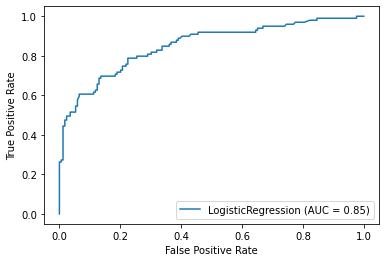

In [127]:
metrics.plot_roc_curve(log_reg,X_test_tf,y_test)

- False Positive Rate vs True Positive Rate → for each threshold

<img src="https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/roc_comparison.png" width=70%>

In [128]:
## We can use the AUC to judge how good the model is  (higher AUC the better)
# but it needs something new: y_score.
metrics.roc_auc_score

In [1]:
## Get y_score or y_score_prob from the log_reg decision function / predict proba


In [2]:
# Scikit-learn's built in roc_curve method returns the fpr, tpr, and threshold
# for various decision boundaries given the case member probabilites



In [3]:
## we can get the auc from y_test and y_score


In [4]:
## Can also calc from fpr,tpr


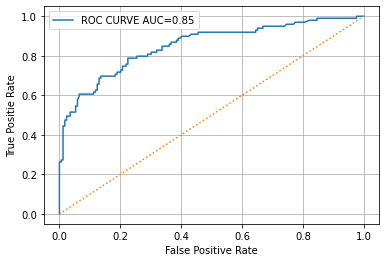

In [133]:
## Plot The ROC Curve
fig, ax = plt.subplots(nrows=1,figsize=(6,4))

# ax =axes[0]
## PLot fpt vs tpr
ax.plot(fpr,tpr, label=f'ROC CURVE AUC={round(metrics.auc(fpr, tpr),2)}')

## Plot a diagnonal line to indicate worthless model
ax.plot([0,1],[0,1],ls=':',)

## Properly Label axes and title figure
ax.set(xlabel='False Positive Rate',ylabel='True Positie Rate')
## Add legend and grid

ax.legend()
ax.grid()


In [5]:
## Using sklearn's built-in andn making it match ours above


# Activity: Make an `evaluate_classification` function

- Write a function called `evaluate_classification`
- It should accept (at minimum): 
    - model (sklearn model)
    - X_test
    - y_test
    
- ***Ideally you should also accept X_train and y_train to compare results to check for overfitting. ?***
- It should produce:
    - Classification metrics printed
    - Confusion Matrix displayed
    - roc_auc curve displayed
    
    
- Then revisit some of the questions we had from last class re: scaling, LogisticRegression parameters

In [8]:

def evaluate_classification():
    pass

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

        Died       0.83      0.85      0.84       169
    Survived       0.73      0.70      0.71        99

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.79      0.79      0.79       268

------------------------------------------------------------


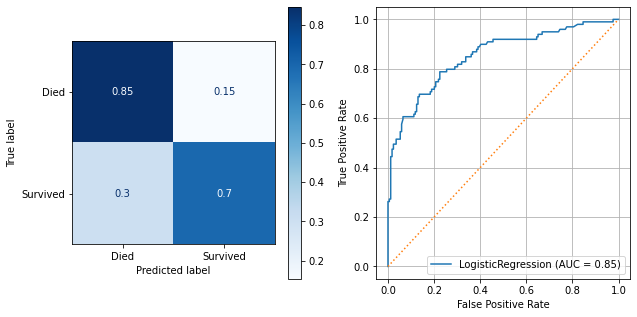

In [136]:
## Fit and evaluate a logistic regression 
params  = dict(C=1e5, solver='liblinear')
log_reg = LogisticRegression(**params)
log_reg.fit(X_train_tf, y_train)

evaluate_classification(log_reg,X_test_tf,y_test,
                        classes=['Died','Survived']);#,label=str(params));

# How to select the best values for our LogisticRegression's hyperparameters

## Hyperparameter Tuning: GridSearchCV 

- C = regularization strenght (inverse)
- penalty: 'l1','l2','elasticnet'
- solver: (see below)
#### `solver` Parameter
https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

- The solvers implemented in the class LogisticRegression are “liblinear”, “newton-cg”, “lbfgs”, “sag” and “saga”:

- The solver “liblinear” uses a coordinate descent (CD) algorithm, and relies on the excellent C++ LIBLINEAR library, which is shipped with scikit-learn. However, the CD algorithm implemented in liblinear cannot learn a true multinomial (multiclass) model; instead, the optimization problem is decomposed in a “one-vs-rest” fashion so separate binary classifiers are trained for all classes. This happens under the hood, so LogisticRegression instances using this solver behave as multiclass classifiers.





In [137]:
import warnings
warnings.filterwarnings('ignore')

In [138]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

```python
params = {'C':[0.001, 0.01, 0.1, 1, 10, 100,1e6,1e12],
        'penalty':['l1','l2','elastic_net'],
        'solver':["liblinear", "newton-cg", "lbfgs", "sag","saga"],}
```

In [139]:
## make gridseach

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000000.0,
                               1000000000000.0],
                         'penalty': ['l1', 'l2', 'elastic_net'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']})

In [9]:
## fit grid and show best_params


In [10]:
## get best_esinmtaor_


In [11]:
## use our evaluate function with the best model


### What about if we wanted better recall?


> All named scoring options in sklearn:
    - https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

In [145]:
###  paste our code and change scoring='recall'


{'C': 100, 'penalty': 'l2'}

In [13]:
## evaluate


# Class Imbalance

## Class Imbalance Problems Lab

In [16]:
df = pd.read_csv('creditcard.csv.gz')
df

NameError: name 'pd' is not defined

In [17]:
target = 'Class'
y = df[target].copy()
X = df.drop(columns=target).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

y_train.value_counts(1)

NameError: name 'df' is not defined

### When metrics can be misleading...
- i.e. accuracy


In [ ]:
# from sklearn
params = dict(fit_intercept=False,C=1e12, solver='liblinear')
regr = LogisticRegression(**params)#fit_intercept=False,C=1e12, solver='liblinear')
regr.fit(X_train, y_train)

regr.score(X_test,y_test)

> ### Woohoo! We must have an amazing model!!...

In [ ]:
evaluate_classification(regr,X_test, y_test)#,label='Imbalanced');

In [ ]:
y_test.value_counts(normalize=True)

### DummyClassifier for Dummies

In [ ]:
from sklearn.dummy import DummyClassifier

## Let's guess 0 for every observation
dummy = DummyClassifier(strategy='constant',constant=0)

preds = dummy.fit(X_train,y_train).predict(X_test)

## How did we do?
dummy.score(X_test,y_test)

In [ ]:
evaluate_classification(dummy,X_test, y_test)#,label='Dummy');

> So what can we do?

## Options for Dealing with Class Imbalance

- Using `class_weight` parameter 
- Oversampling the minority class
- Undersampling the majority class

In [ ]:
## Baseline Model using lesson paras
regr = LogisticRegression(**params)
regr.fit(X_train, y_train)
evaluate_classification(regr,X_test,y_test)#,label="BASELINE" )
print(params)#str(params))

### Solution 1: `class_weight="balanced"`


In [ ]:
regr = LogisticRegression(class_weight='balanced',**params)
regr.fit(X_train, y_train)
evaluate_classification(regr,X_test,y_test)#,label='balanced')

### Solution 2: Oversampling minority class with SMOTE

In [ ]:
y_train.value_counts(0)

In [ ]:
# !pip install -U imblearn
from imblearn.over_sampling import SMOTE,SMOTENC

In [ ]:
smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_sample(X_train,y_train)
pd.Series(y_train_smote).value_counts()

In [ ]:
regr = LogisticRegression(**params)#class_weight='balanced',C=1e5, solver='liblinear')
regr.fit(X_train_smote, y_train_smote)
evaluate_classification(regr,X_test,y_test)#,label='SMOTE')

### Solution 3: Undersampling majority class

In [ ]:
df_balance = pd.concat([X_train, y_train],axis=1)
df_balance

In [ ]:
n_samples = df_balance['Class'].value_counts().min()
n_samples

In [ ]:
df_balance.groupby('Class').groups.keys()

In [ ]:
df_resample = pd.DataFrame()
for grp,idx in df_balance.groupby('Class').groups.items():
    
    resample = df_balance.loc[idx].sample(n=n_samples,random_state=123)
    df_resample = pd.concat([df_resample,resample],axis=0)
    
display(df_resample.head(), df_resample["Class"].value_counts())



In [ ]:
X_train_under = df_resample.drop('Class',axis=1).copy()
y_train_under = df_resample['Class'].copy()

regr = LogisticRegression(**params)#C=1e5, solver='liblinear')
regr.fit(X_train_under, y_train_under)
evaluate_classification(regr,X_test,y_test)

# APPENDIX 

## Additional ROC Curve 

### What Distributions Would Work Well in Classifying?

<img src="https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/roc_crossover.png" width=60%>

### Defining the Threshold

<img src="https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/auc_rates.png" width=60%>

In [ ]:
# # Interactive ROC curve
# from IPython.display import IFrame
# IFrame('http://www.navan.name/roc/', width=800, height=600)